In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from matplotlib.ticker import FuncFormatter
from ito_diffusions import SABR_AS
from volmodels import *
plt.style.use('dark_background')

In [2]:
params = {
    'font.size': 14,
    'figure.figsize': (11,18),
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
}
plt.rcParams.update(params)

In [3]:
T = 1
SCHEME_STEPS = int(1e4)
ONE_BP = 1e-4
ONE_PCT = 1e-2
N_STRIKES = 500

## Diffusion equation

* $dX_t = \sigma_tC(X_t)dW_t$

* $d\sigma_t = \eta \sigma_tdB_t$

* $d<W,B>_t = \rho dt$

* $C(x) = e^{-c\log(\frac{x}{K_{max}})^2}$


## Sample paths

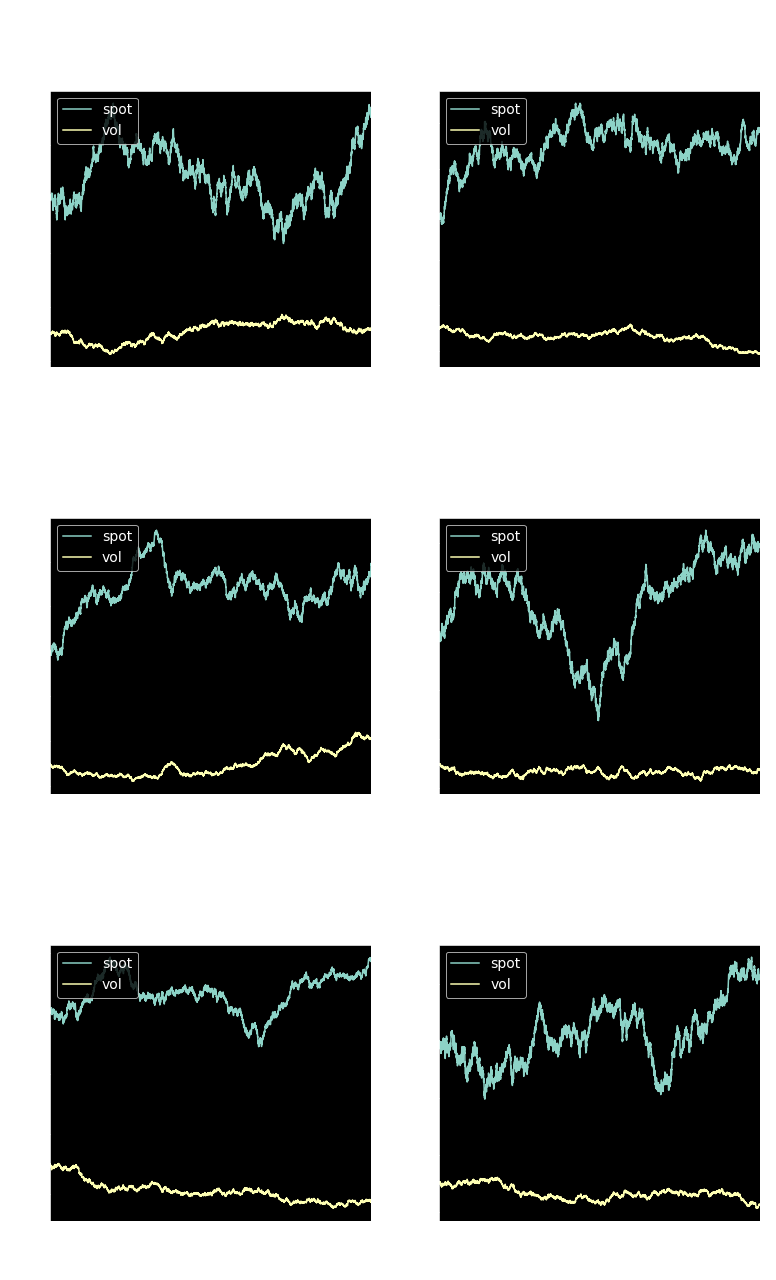

In [4]:
fig, axes = plt.subplots(nrows=3, ncols=2)

x0 = [1, 0.5]

params = [
    [0.4, 0.1],
    [0.4, 0.3],
    [0.4, 0.8],
    [0.8, 0.1],
    [0.8, 0.3],
    [0.8, 0.8],
]

X = SABR_AS(x0=x0, T=T, scheme_steps=SCHEME_STEPS, keys=['spot', 'vol'])

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        vov = 0.2
        rho = -0.4
        K_max= params[i+3*j][0]
        c = params[i+3*j][1]
        
        X.K_max = K_max
        X.vov = vov
        X.rho = rho
        X.c = c
        
        df = X.simulate()
        df.plot(kind='line', ax=ax)

        ax.set_xlabel('time\n')
        ax.set_ylabel('spot')
        ax.legend(loc='upper left')
        ax.set_title(r'K_max={:.2f}'.format(K_max)+'\n'\
                     r'c={:.2f}'.format(c)+'\n'\
                     r'vov={:.0%}'.format(vov)+'\n'\
                     r'$\rho$={:.0%}'.format(rho))

plt.tight_layout()
plt.show()

## Local vol shape

This local vol form vanishes at 0 and for large strikes, reaches its maximum at strike $K_{max}$ and the spatial extension around $K_{max}$ is controlled by $c$ :

$
\sigma_{loc}(x) = e^{-c\log(\frac{x}{K_{max}})^2}
$

/home/sauxpa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


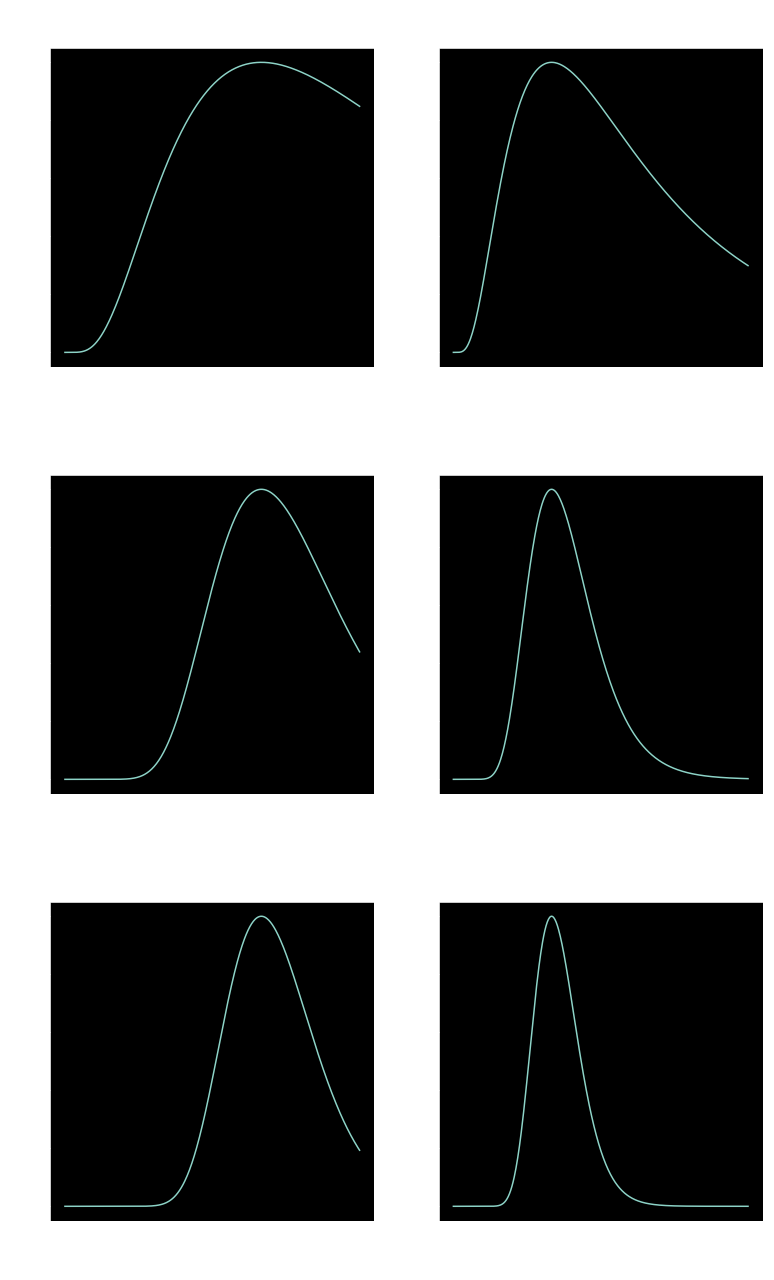

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=2)

xs = np.linspace(0, 3*ONE_PCT, N_STRIKES)

def local_vol_gen(K_max, c, x):
    return np.exp(-c*np.log(x/K_max)**2)

params = [
    [2*ONE_PCT, 1.0],
    [2*ONE_PCT, 5.0],
    [2*ONE_PCT, 10.0],
    [1*ONE_PCT, 1.0],
    [1*ONE_PCT, 5.0],
    [1*ONE_PCT, 10.0],
]

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        K_max = params[i+3*j][0]
        c = params[i+3*j][1]
        
        local_vol = partial(local_vol_gen, K_max, c)
        
        ax.plot(xs, local_vol(xs))
        ax.set_xlabel('strike\n')
        ax.set_ylabel('local vol')
        ax.set_title(r'K_max={:.2f}'.format(K_max)+'\n'\
                     r'c={:.2f}'.format(c)
                    )
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.tight_layout()
plt.show()

## Numerical experiments

In [6]:
f = 1*ONE_PCT
K_max = 50*ONE_BP
c = 0.1
vov = 40*ONE_PCT
rho = -40*ONE_PCT
K_lo = 0*ONE_BP
K_hi = 2*ONE_PCT
sigma_0 = 20*ONE_BP

In [7]:
Model_LN = SABR_AS_LN(K_max=K_max, 
                      c=c, 
                      vov=vov,
                      rho=rho,
                      f=f,
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      K_lo=K_lo,
                      K_hi=K_hi,
                      strike_type='strike'
                     )
Model_N = SABR_AS_N(K_max=K_max,
                    c=c,
                    vov=vov,
                    rho=rho,
                    f=f,
                    sigma_0=sigma_0,
                    n_strikes=N_STRIKES,
                    K_lo=K_lo, 
                    K_hi=K_hi, 
                    strike_type='strike'
                   )

/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:161: RuntimeWarning: divide by zero encountered in double_scalars
  log_moneyness = np.log(self.f/K)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:164: RuntimeWarning: divide by zero encountered in log
  C_f_avg_adj = np.exp(-self.c*np.log(f_avg_adj)**2)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:166: RuntimeWarning: divide by zero encountered in log
  gamma_1 = -(2*self.c*np.log(f_avg_adj))/f_avg
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:167: RuntimeWarning: divide by zero encountered in log
  gamma_2 = (2*self.c*(-1+np.log(f_avg_adj)+2*self.c*np.log(f_avg_adj)**2))/(f_avg**2)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:167: RuntimeWarning: invalid value encountered in double_scal

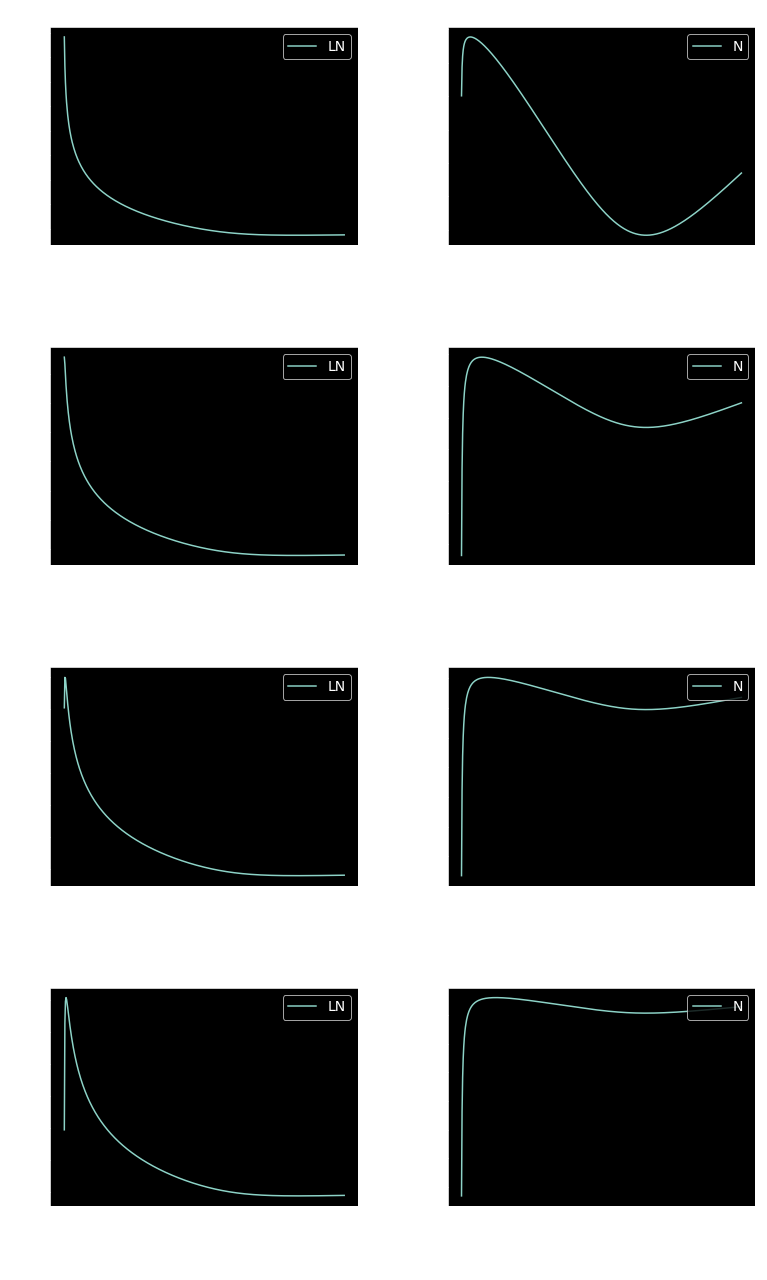

In [8]:
#xlabel = 'logmoneyness\n\n'
xlabel = 'strike\n\n'
ylabel = 'implied vol'
labels = ['LN', 'N']

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=2)

for i, ax_row in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    #x_grid = Model_LN.logmoneyness_grid
    x_grid = Model_LN.strike_grid

    models = [Model_LN, Model_N]
    for j, ax in enumerate(ax_row):
        model = models[j]
        label = labels[j]
        smile = list(model.smile.values())

        ax.plot(x_grid, smile, label=label)

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.set_title('expiry={}y'.format(T_expiry))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
plt.tight_layout()
plt.show()

## Implied probability density

As with Hagan's original formula, issues arise on the left wing for long expiries, although in the sense that higher density on the tail is unrealistic. However the implied density seem to remain positive, so overall the expansion seems more stable.

/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:161: RuntimeWarning: invalid value encountered in log
  log_moneyness = np.log(self.f/K)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:162: RuntimeWarning: invalid value encountered in sqrt
  f_avg = np.sqrt(self.f*K)
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_sabr_as.py:96: RuntimeWarning: invalid value encountered in log
  return (np.exp(-1/(4*self.c))*self.K_max*np.sqrt(np.pi)                *erfi((1+2*self.c*np.log(x/self.K_max))/(2*np.sqrt(self.c))))/(2*np.sqrt(self.c))
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/volmodels_base.py:27: RuntimeWarning: invalid value encountered in log
  d1          = 1 / ( vol * np.sqrt( T_expiry ) ) * ( np.log( f / K ) + ( 0.5 * vol ** 2 ) * T_expiry )
/home/sauxpa/Documents/python_scripts/Quant/diffusions/vol_models/volmodels/vo

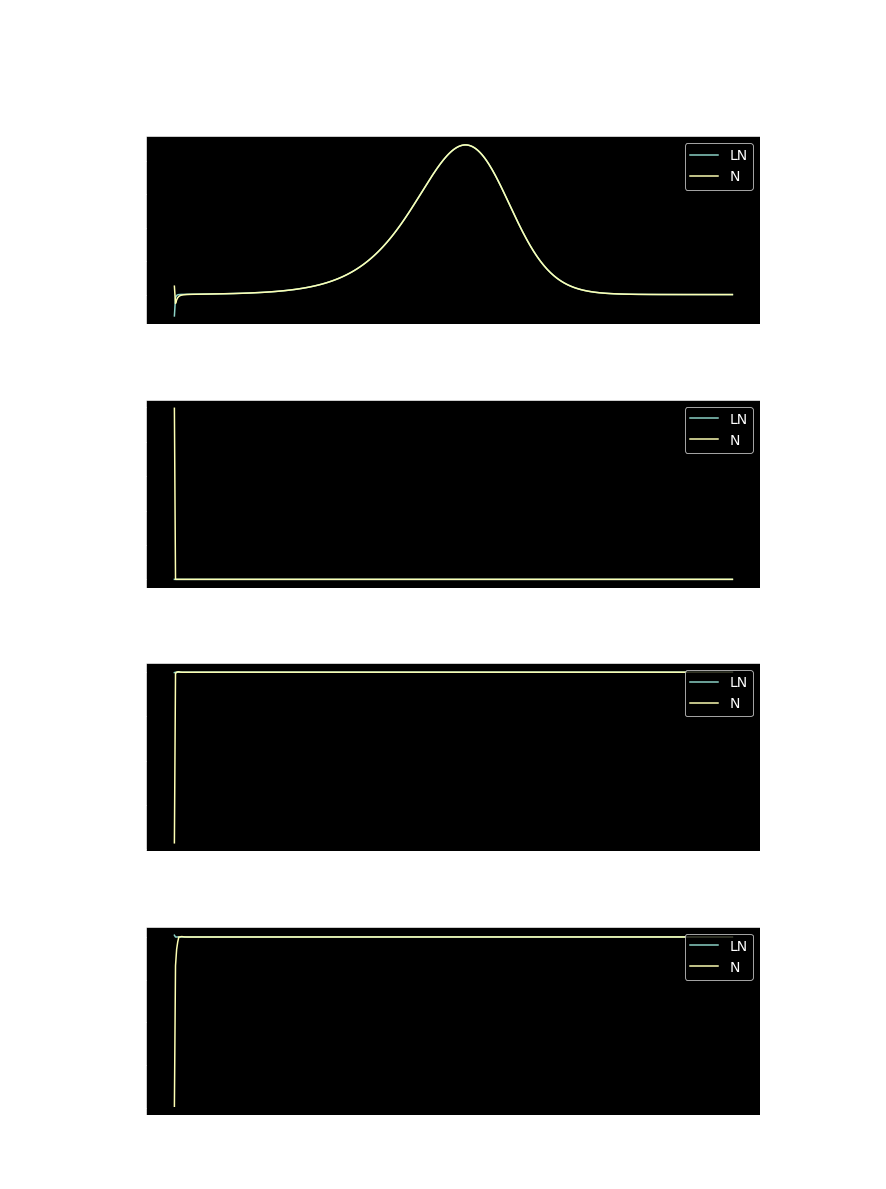

In [9]:
#xlabel = 'logmoneyness\n\n'
xlabel = 'strike\n\n'
ylabel = 'pdf'

T_expiries = [1.0, 5.0, 10.0, 20.0]

fig, axes = plt.subplots(nrows=4, ncols=1)

plt.suptitle(r'$f$={:.2%}'.format(Model_LN.f)+', '+\
             r'c={:.2f}'.format(Model_LN.c)+', '+\
             r'K_max={:.2%}'.format(Model_LN.K_max)+', '+\
             r'vov={:.0%}'.format(Model_LN.vov)+', '+\
             r'$\rho$={:.0%}'.format(Model_LN.rho)+', '+\
             r'ATM(LN)={:.2%}, ATM(N)={:.2f}bps'.format(Model_LN.ATM, Model_N.ATM/ONE_BP)+', '+\
             r'$\sigma_0$={:.2%}'.format(Model_LN.sigma_0)
            )

for i, ax in enumerate(axes):
    T_expiry = T_expiries[i]
    Model_LN.T_expiry = T_expiry
    Model_N.T_expiry = T_expiry
    
    #x_grid = Model_LN.logmoneyness_grid
    x_grid = Model_LN.strike_grid
    
    pdf_LN = list(Model_LN.pdf_curve.values())
    pdf_N = list(Model_N.pdf_curve.values())

    ax.plot(x_grid, pdf_LN, label='LN')
    ax.plot(x_grid, pdf_N, label='N')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')

    ax.set_title(r'expiry={}y'.format(T_expiry))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))

plt.subplots_adjust(hspace=0.4)
plt.show()

## Backbone i.e ATM vol move implied by forward move

The idea behind this local vol form is to ensure increasing vol for decreasing forward, an observed behaviour in rates markets when forwards are near a perceived rates floor.

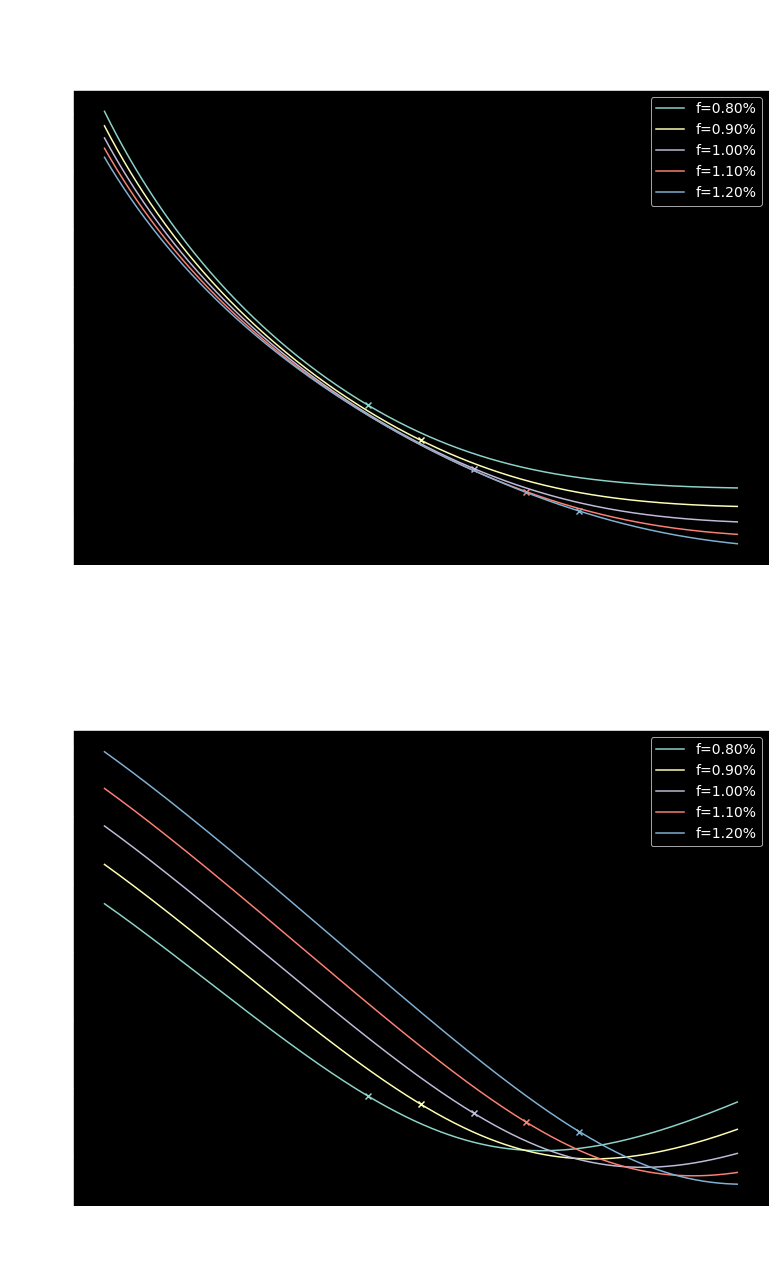

In [10]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 1*ONE_PCT

f_shocks = [
    -20*ONE_BP, 
    -10*ONE_BP, 
    0, 
    10*ONE_BP, 
    20*ONE_BP
]

vov = 40*ONE_PCT
rho = -40*ONE_PCT

sigma_0 = 20*ONE_BP
K_max = 50*ONE_BP
c = 0.1

K_lo = 30*ONE_BP
K_hi = 150*ONE_BP

Model_LN = SABR_AS_LN(c=c, 
                      K_max=K_max, 
                      vov=vov,
                      rho=rho,
                      f=f,
                      sigma_0=sigma_0,
                      n_strikes=N_STRIKES,
                      T_expiry=1.0,
                      K_lo=K_lo, 
                      K_hi=K_hi,
                      strike_type='strike'
                     )
Model_N = SABR_AS_N(c=c,
                    K_max=K_max,
                    vov=vov,
                    rho=rho,
                    f=f,
                    sigma_0=sigma_0,
                    n_strikes=N_STRIKES,
                    T_expiry=1.0,
                    K_lo=K_lo, 
                    K_hi=K_hi, 
                    strike_type='strike'
                   )

models = [Model_LN, Model_N]

fig, axes = plt.subplots(nrows=2, ncols=1)
    
for i, ax in enumerate(axes):
    model = models[i]
    for f_shock in f_shocks:
        model.f = f+f_shock
        smile = list(model.smile.values())
        label = 'f={:.2%}'.format(f+f_shock)
        ax.plot(model.strike_grid, smile, label=label)
        ax.scatter([model.f], [model.ATM], marker='x')

        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(loc='upper right')
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
        ax.set_title('{}\n'.format(model.vol_type)\
                     +'c={:.2f}'.format(c) +'\n'
                     +'K_max={:.2f}'.format(K_max) +'\n')

plt.tight_layout()
plt.show()

## Parameter sensitivities

Vol of vol controls the convexity of the smile, $\rho$ the skew (i.e rotation around the ATM).
Both have little to no effect on the ATM itself.

$\sigma_0$ controls the ATM via parallel shifts of the whole smile.

$K_{max}$ and $c$ control the backbone shape.

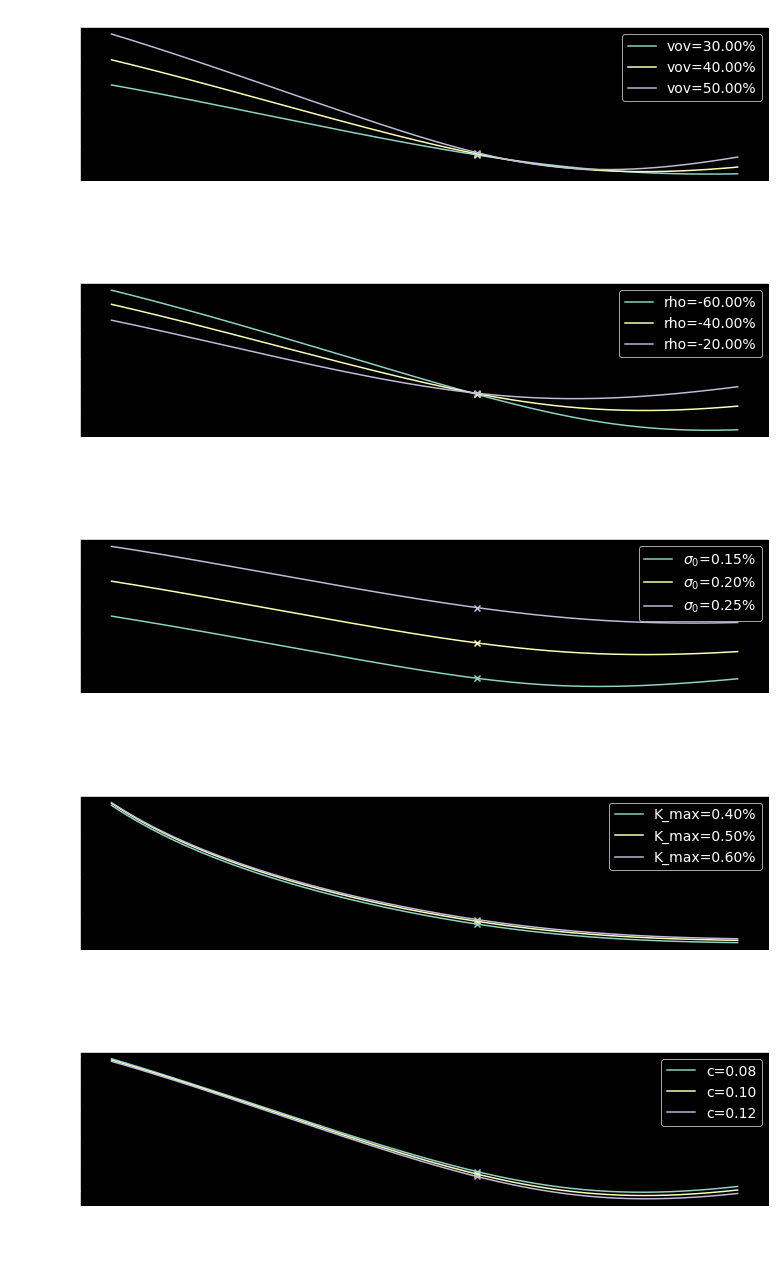

In [11]:
xlabel = 'strike\n\n'
ylabel = 'implied vol'

f = 1*ONE_PCT

vov_shocks = [-10*ONE_PCT, 0, 10*ONE_PCT]
rho_shocks = [-20*ONE_PCT, 0, 20*ONE_PCT]
sigma_0_shocks = [-5*ONE_BP, 0, 5*ONE_BP]
K_max_shocks = [0.8, 1, 1.2]
c_shocks = [0.8, 1, 1.2]

vov = 40*ONE_PCT
rho = -40*ONE_PCT

sigma_0 = 20*ONE_BP
K_max = 50*ONE_BP
c = 0.1

K_lo = 30*ONE_BP
K_hi = 150*ONE_BP

fig, axes = plt.subplots(nrows=5, ncols=1)

ax = axes[0]  
model = SABR_AS_N(c=c, 
                  K_max=K_max,
                  vov=vov,
                  rho=rho,
                  f=f,
                  sigma_0=sigma_0,
                  n_strikes=N_STRIKES,
                  T_expiry=1,
                  K_lo=K_lo, 
                  K_hi=K_hi,
                  strike_type='strike'
                 )

for vov_shock in vov_shocks:
    model.vov = vov+vov_shock
    
    smile = list(model.smile.values())
    label = 'vov={:.2%}'.format(vov+vov_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Vol of vol shock')

ax = axes[1]
model = SABR_AS_N(c=c, 
                  K_max=K_max,
                  vov=vov,
                  rho=rho,
                  f=f,
                  sigma_0=sigma_0,
                  n_strikes=N_STRIKES,
                  T_expiry=1.0,
                  K_lo=K_lo, 
                  K_hi=K_hi,
                  strike_type='strike'
                 )

for rho_shock in rho_shocks:
    model.rho = rho+rho_shock
    
    smile = list(model.smile.values())
    label = 'rho={:.2%}'.format(rho+rho_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Correlation shock')
    
ax = axes[2]
model = SABR_AS_N(c=c, 
                  K_max=K_max,
                  vov=vov, 
                  rho=rho,
                  f=f,
                  sigma_0=sigma_0,
                  n_strikes=N_STRIKES,
                  T_expiry=1.0,
                  K_lo=K_lo,
                  K_hi=K_hi,
                  strike_type='strike'
                 )

for sigma_0_shock in sigma_0_shocks:
    model.sigma_0 = sigma_0+sigma_0_shock

    smile = list(model.smile.values())
    label = r'$\sigma_0$={:.2%}'.format(sigma_0+sigma_0_shock)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title('Initial vol shock')

ax = axes[3]
model = SABR_AS_LN(c=c, 
                   K_max=K_max,
                   vov=vov,
                   rho=rho,
                   f=f,
                   sigma_0=sigma_0,
                   n_strikes=N_STRIKES,
                   T_expiry=1.0,
                   K_lo=K_lo, 
                   K_hi=K_hi,
                   strike_type='strike'
                  )

for K_max_shock in K_max_shocks:
    model.K_max = K_max*K_max_shock
    smile = list(model.smile.values())
    label = r'K_max={:.2%}'.format(model.K_max)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'K_max shock')

ax = axes[4]
model = SABR_AS_N(c=c, 
                  K_max=K_max,
                  vov=vov,
                  rho=rho,
                  f=f,
                  sigma_0=sigma_0,
                  n_strikes=N_STRIKES,
                  T_expiry=1,
                  K_lo=K_lo, 
                  K_hi=K_hi,
                  strike_type='strike'
                 )

for c_shock in c_shocks:
    model.c = c*c_shock
    smile = list(model.smile.values())
    label = r'c={:.2f}'.format(model.c)
    ax.plot(model.strike_grid, smile, label=label)
    ax.scatter([model.f], [model.ATM], marker='x')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(loc='upper right')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.2%}'.format(x)))
    ax.set_title(r'$c$ shock')
    
plt.tight_layout()
plt.show()